%% Machine Learning Online Class - Exercise 4 Neural Network Learning

%  Instructions
%  ------------
% 
%  This file contains code that helps you get started on the
%  linear exercise. You will need to complete the following functions 
%  in this exericse:
%
%     sigmoidGradient.m
%     randInitializeWeights.m
%     nnCostFunction.m
%
%  For this exercise, you will not need to change any code in this file,
%  or any other files other than those mentioned above.

In [2]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from scipy.io import loadmat  
import seaborn as sbs
import matplotlib.image as mpimg
import scipy.optimize as op
from scipy.optimize import minimize
%matplotlib inline

In [2]:
#%% Setup the parameters you will use for this exercise
input_layer_size  = 400;  #% 20x20 Input Images of Digits
hidden_layer_size = 25;   #% 25 hidden units
num_labels = 10; #% 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

In [4]:
def displayData(sel):
    m,n = sel.shape
    example_width = int(np.sqrt(n))
    example_height = int(n/example_width)
    display_rows = int(np.sqrt(m))
    display_cols = int(np.sqrt(m))
    pad = 1;
    display_array = np.ones((pad + display_rows * (example_height + pad),  pad + display_cols * (example_width + pad)))
    curr_ex = 0;
    for j in range(display_rows):
        for i in range(display_cols):
            #% Copy the patch
            #% Get the max value of the patch
            #max_val = max(abs(X(curr_ex, :)));
            array_temp = (sel[curr_ex,:].reshape((example_height,example_width))).T;
            u1=pad + j * (example_height + pad);
            u2=pad + j * (example_height + pad)+example_height;
            v1=pad + i * (example_width + pad);
            v2=pad + i * (example_width + pad)+example_width;
            display_array[u1:u2,v1:v2] = array_temp
            curr_ex = curr_ex + 1;
    return display_array

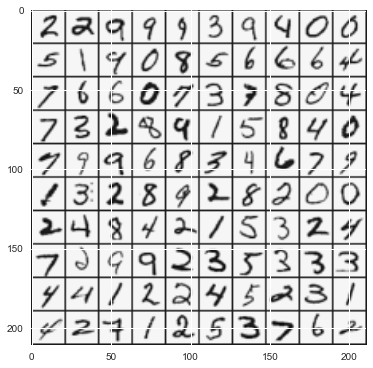

In [7]:
data = loadmat('ex4data1.mat');
X=np.matrix(data['X'])
y=np.matrix(data['y'])
m,n = X.shape
#% Randomly select 100 data points to display
rand_indices = np.random.permutation(m)
sel = data['X'][rand_indices[0:100], :];
sel.shape
display_array = displayData(sel)
plt.figure(figsize=(6,6))
plt.imshow(display_array)

In [5]:
def sigmoid(z):
    #%SIGMOID Compute sigmoid function
    #%g = SIGMOID(z) computes the sigmoid of z.

    #% You need to return the following variables correctly 
    g = np.matrix(np.zeros(np.shape(z)));

#% ====================== YOUR CODE HERE ======================
#% Instructions: Compute the sigmoid of each value of z (z can be a matrix,vector or scalar).
    g = np.divide(1,(1+np.exp(-z)));    
    return g

def sigmoidGradient(z):
    g = np.multiply(sigmoid(z),(1-sigmoid(z)));
    return g


In [6]:
#%% ================ Part 2: Loading Parameters ================
#% In this part of the exercise, we load some pre-initialized 
#% neural network parameters.

print('Loading Saved Neural Network Parameters ...')
para = loadmat('ex4weights.mat');
theta1 = para['Theta1']
theta2 = para['Theta2']
t1_temp = theta1.flatten(1)
t2_temp = theta2.flatten(1)
theta1 = np.matrix(theta1)
theta2 = np.matrix(theta2)
nn_params = np.concatenate([t1_temp,t2_temp])

Loading Saved Neural Network Parameters ...


In [7]:
theta1.shape

(25L, 401L)

%% ================ Part 3: Compute Cost (Feedforward) ================
%  To the neural network, you should first start by implementing the
%  feedforward part of the neural network that returns the cost only. You
%  should complete the code in nnCostFunction.m to return cost. After
%  implementing the feedforward to compute the cost, you can verify that
%  your implementation is correct by verifying that you get the same cost
%  as us for the fixed debugging parameters.
%
%  We suggest implementing the feedforward cost *without* regularization
%  first so that it will be easier for you to debug. Later, in part 4, you
%  will get to implement the regularized cost.

In [8]:
def forwordprop(X,theta1,theta2,input_layer_size, hidden_layer_size, num_labels):
    m,n = X.shape
    A1 = np.c_[np.ones(m), X]
    Z2 = A1*theta1.T;
    A2 = sigmoid(Z2);
    A2 = np.c_[np.ones(m), A2];
    Z3 = A2*theta2.T;
    h = sigmoid(Z3);
    return A1,Z2,A2,Z3,h
    

In [9]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    J=0
    m,n = X.shape
    t1_t=nn_params[0:hidden_layer_size*(input_layer_size+1)]
    t2_t=nn_params[hidden_layer_size*(input_layer_size+1):len(nn_params)]
    theta1=t1_t.reshape(hidden_layer_size,input_layer_size+1,order='F')
    theta2=t2_t.reshape(num_labels,hidden_layer_size+1,order='F') 
    #theta1(25,401) theta2(10,26)
    theta1_grad = np.zeros(theta1.shape);
    theta2_grad = np.zeros(theta2.shape);
    #forward propagation
    A1,Z2,A2,Z3,h = forwordprop(X,theta1,theta2,input_layer_size, hidden_layer_size, num_labels)
    #A1(5000,401) Z2(5000,25) A2(5000,26) Z3(5000,10) h(5000,10)
    for i in range(m):
        y_temp = np.zeros((num_labels,1)) #y_temp(10,1)
        y_temp[y[i]-1]=1;
        y_temp=y_temp.T #y_temp(1,10)
        J_temp = np.multiply(-y_temp, np.log(h[i,:]))-np.multiply((1-y_temp),np.log(1-h[i,:]))
        J = np.sum(J_temp)+J;
        delta3 = h[i,:]-y_temp
        theta2_grad = theta2_grad+delta3.T*A2[i,:]
        Z2_t=np.c_[np.ones(1),Z2[i,:]] #Z2_t(1,26)
        delta2 = np.multiply((delta3*theta2),sigmoidGradient(Z2_t)); #delta2(1,26)
        delta2 = delta2[0,1:];
        theta1_grad = theta1_grad+delta2.T*A1[i,:];
    J=J/m
    TT1=np.square(theta1[:,1:]);
    TT2=np.square(theta2[:,1:]);
    J=J+float(lamb)/(2*m)*(sum(sum(TT1))+sum(sum(TT2)));
    #graduation
    theta1_grad[:,1:] = theta1_grad[:,1:] + np.multiply(lamb,theta1[:,1:]);
    theta2_grad[:,1:] = theta2_grad[:,1:] + np.multiply(lamb,theta2[:,1:]);
    grad = np.concatenate((np.ravel(theta1_grad), np.ravel(theta2_grad)))
    return J,grad

In [10]:
print('Using Neural Network ...')
#% Weight regularization parameter (we set this to 0 here).
lamb = 10;
J,grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb);
#lamb=1 J=0.383770 
#lamb=0 J=0.287629

Using Neural Network ...


In [11]:
Result = minimize(fun=nnCostFunction, x0=nn_params, args=(input_layer_size, hidden_layer_size, num_labels, X, y, lamb),  
                method='TNC', jac=True, options={'maxiter': 250})

In [12]:
params = Result.x
print Result
t1_t=params[0:hidden_layer_size*(input_layer_size+1)]
t2_t=params[hidden_layer_size*(input_layer_size+1):len(params)]
theta1=t1_t.reshape(hidden_layer_size,input_layer_size+1,order='F')
theta2=t2_t.reshape(num_labels,hidden_layer_size+1,order='F') 
A1,Z2,A2,Z3,h = forwordprop(X,theta1,theta2,input_layer_size, hidden_layer_size, num_labels)  
pred = np.array(np.argmax(h, axis=1) + 1)  
accuracy = np.mean((pred==y)*1)*100
print('Training Set Accuracy: %f'% accuracy);

  status: 1
 success: True
    nfev: 47
     fun: 1.2490361044573657
       x: array([-0.02256239, -0.09838113,  0.11615605, ..., -2.11014003,
       -2.1319153 , -1.32752042])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
     jac: array([  3.09356383e-01,  -1.05624163e-07,   2.19414683e-08, ...,
        -1.99490552e+00,   9.01222757e+00,  -9.40855483e+00])
     nit: 1
Training Set Accuracy: 97.520000


In [13]:
y_pred.shape

NameError: name 'y_pred' is not defined

In [ ]:
 Z2_t=np.c_[np.ones(1),Z2[i,:]]

In [ ]:
B1_tt=A1_t.reshape(hidden_layer_size,input_layer_size+1,order='F')